In [31]:
from numba import jit
import numpy as np


def trim_borders(array, top=0, bottom=0, left=0, right=0):
    if len(array.shape) != 2:
        raise ValueError("Input array must be 2D")

    return array[top : array.shape[0] - bottom, left : array.shape[1] - right]


@jit(nopython=True)
def fix_borders(grid):
    y1 = grid.shape[1] - 1

    for x1 in range(grid.shape[0]):
        grid[x1, y1] = grid[x1, y1 - 1]
        grid[x1, 0] = grid[x1, 1]
    x2 = grid.shape[0] - 1
    for y2 in range(grid.shape[1]):
        grid[x2, y2] = grid[x2 - 1, y2]
        grid[0, y2] = grid[1, y2]

    return grid


Loaded 0 files
Loaded 50 files
Loaded 100 files
Loaded 150 files
Loaded 200 files
Loaded 250 files
Loaded 300 files
Loaded 350 files
Loaded 400 files
Loaded 450 files
Loaded 500 files
Loaded 550 files
Loaded 600 files
Loaded 650 files
Loaded 700 files
Loaded 750 files
Loaded 800 files
Loaded 850 files
Loaded 900 files
Loaded 950 files
Loaded 1000 files
Loaded 1050 files
Loaded 1100 files
Loaded 1150 files
Loaded 1200 files
Loaded 1250 files
Loaded 1300 files
Loaded 1350 files
Loaded 1400 files
Loaded 1450 files
Loaded 1500 files
Loaded 1550 files
Loaded 1600 files
Loaded 1650 files
Loaded 1700 files
Loaded 1750 files
Loaded 1800 files
Loaded 1850 files
Loaded 1900 files
Loaded 1950 files
Loaded 2000 files
Loaded 2050 files
Loaded 2100 files
Loaded 2150 files
Loaded 2200 files
Loaded 2250 files
Loaded 2300 files
Loaded 2350 files
Loaded 2400 files
Loaded 2450 files
Loaded 2500 files
Loaded 2550 files
Loaded 2600 files
Loaded 2650 files
Loaded 2700 files
Loaded 2750 files
Loaded 2800 fil

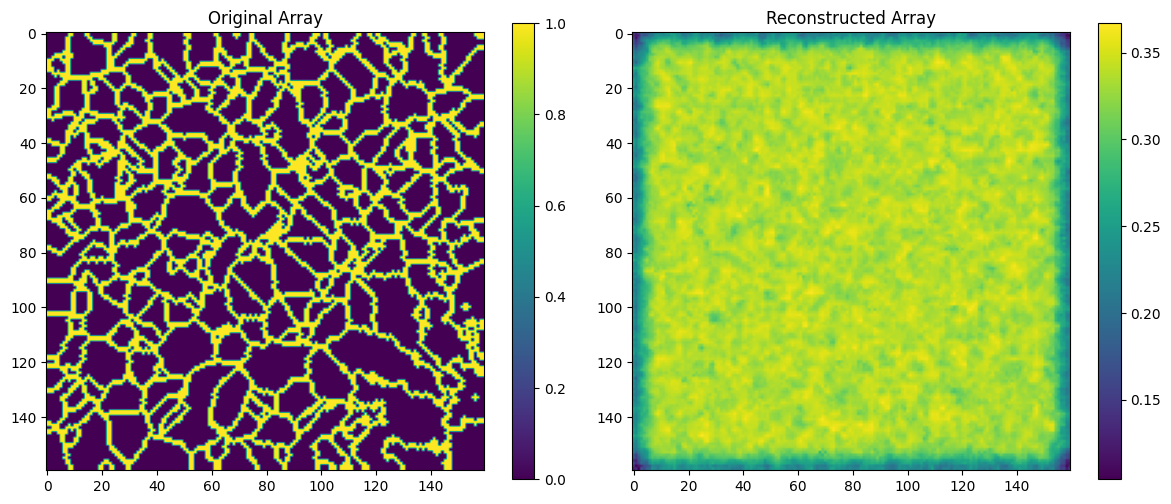

[-0.47778252 -0.04348513 -0.30404538  0.06837945  0.08469669 -0.6608008
  1.755689   -0.5665165 ]


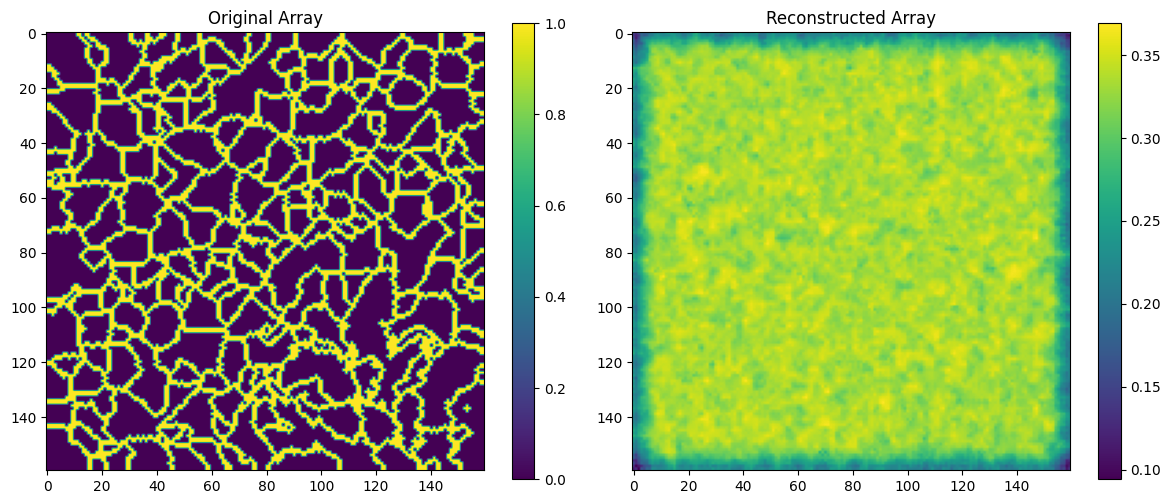

[-0.03008628  0.2774472  -0.1190474   0.24542609  0.37735143 -0.19585037
  1.5505391  -0.41496134]


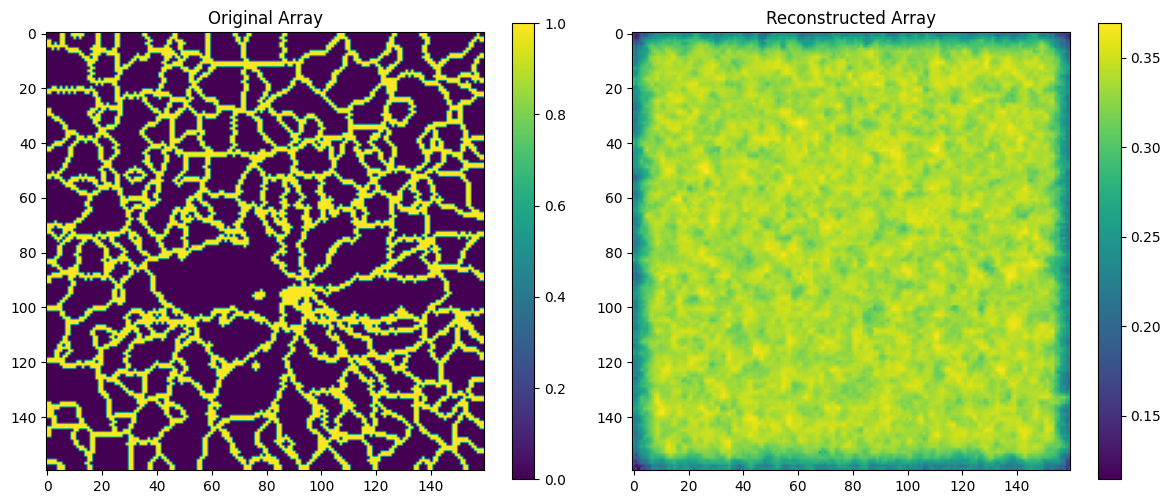

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Encoded data shape: (2204, 8)
Sample encoded vector: [-0.08550287 -0.18791538 -0.13704947 -0.05882863 -0.04634222 -0.82543886
  1.6013145  -0.47338802]


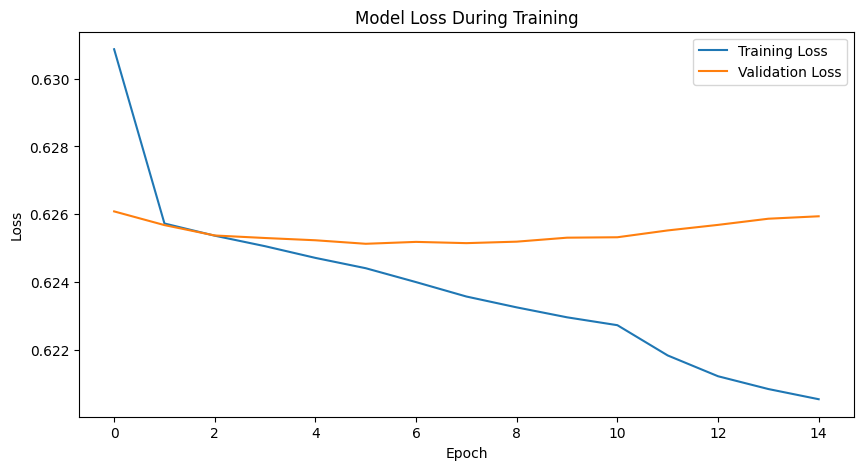

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers


# Function to load and preprocess data
def load_data(directory):
    data = []
    i = 0
    for filename in os.listdir(directory):
        # if i == 1001:
        # break
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath, header=None)
            data.append(
                # trim_borders(df.values, top=1, bottom=1, left=1, right=1)
                fix_borders(trim_borders(df.values, top=1, bottom=1, left=1, right=1))
            )
            if i % 50 == 0:
                print(f"Loaded {i} files")
            i += 1
    return np.array(data)


# Load data
data = load_data("../output40")
print("Data shape:", data.shape)
print("Data shape:", data.shape[1])

size = data.shape[1]

# Reshape for conv2d layers (adding channel dimension)
data = data.reshape((-1, size, size, 1))

# Split data into training and testing sets
X_train, X_test = train_test_split(data, test_size=0.4, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(
    X_train.shape
)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(
    X_test.shape
)

# Define the autoencoder model
input_shape = (size, size, 1)
encoding_dim = 8  # Increased from 64

encoder = models.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), activation="relu", padding="same", strides=2),
        layers.Flatten(),
        layers.Dense(
            encoding_dim, activation="linear"
        ),  # Use linear activation to allow range of values
    ]
)

# Very Simplified Decoder
decoderSize = size // 2  # Adjust according to downsampling in encoder
decoder = models.Sequential(
    [
        layers.Input(shape=(encoding_dim,)),
        layers.Dense(decoderSize * decoderSize * 16, activation="relu"),
        layers.Reshape((decoderSize, decoderSize, 16)),
        layers.Conv2DTranspose(
            1, (3, 3), strides=2, activation="sigmoid", padding="same"
        ),
    ]
)

autoencoder = models.Sequential([encoder, decoder])


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer=optimizer, loss="binary_crossentropy")

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Train the model
history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=15,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test_scaled, X_test_scaled),
    callbacks=[reduce_lr, early_stop],
)

# Evaluate the model
test_loss = autoencoder.evaluate(X_test_scaled, X_test_scaled)
print(f"Test loss: {test_loss}")


# Function to visualize original vs reconstructed arrays
def visualize_reconstruction(original, reconstructed, features, index):
    print(features[index])
    original_2d = original[index].reshape(data.shape[1], data.shape[2])
    reconstructed_2d = reconstructed[index].reshape(data.shape[1], data.shape[2])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    im1 = ax1.imshow(original_2d, cmap="viridis")
    ax1.set_title("Original Array")
    fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(reconstructed_2d, cmap="viridis")
    ax2.set_title("Reconstructed Array")
    fig.colorbar(im2, ax=ax2)
    plt.tight_layout()
    plt.show()


# Reconstruct test data
reconstructed = autoencoder.predict(X_test_scaled)

features = encoder.predict(X_test_scaled)


# Visualize a few examples
for i in range(3):
    visualize_reconstruction(X_test_scaled, reconstructed, features, i)

# Encode data to analyze latent space
encoded_data = encoder.predict(X_test_scaled)
print("Encoded data shape:", encoded_data.shape)
print("Sample encoded vector:", encoded_data[0])

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Loaded 0 files
Loaded 50 files
Loaded 100 files
Loaded 150 files
Loaded 200 files
Loaded 250 files
Loaded 300 files
Loaded 350 files
Loaded 400 files
Loaded 450 files
Loaded 500 files
Loaded 550 files
Loaded 600 files
Loaded 650 files
Loaded 700 files
Loaded 750 files
Loaded 800 files
Loaded 850 files
Loaded 900 files
Loaded 950 files
Loaded 1000 files
Distribution of values in the dataset:
{0: 17408297, 1: 8217303}


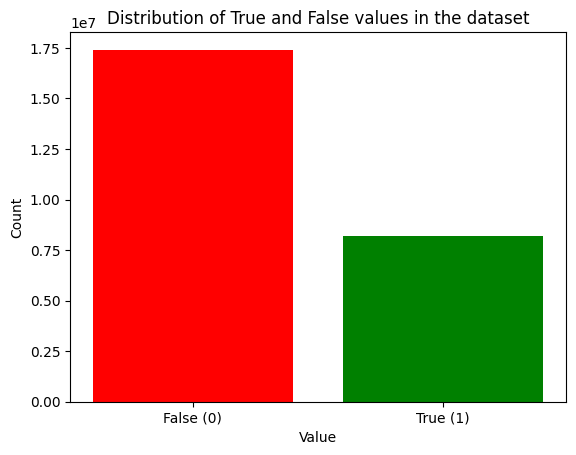

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data
size = 28
num_samples = 1000
data = load_data("../output40")

# Flatten the data to count True/False values
flattened_data = data.flatten()

# Calculate the distribution of True (1) and False (0) values
unique, counts = np.unique(flattened_data, return_counts=True)
distribution = dict(zip(unique, counts))

print("Distribution of values in the dataset:")
print(distribution)

# Visualize the distribution
labels = ["False (0)", "True (1)"]
values = [distribution[0], distribution[1]]

plt.bar(labels, values, color=["red", "green"])
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Distribution of True and False values in the dataset")
plt.show()
